In [1]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

In [3]:
# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read and Peak at Data
df = pd.read_csv("Dataset/Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


In [5]:
df.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label
16019,1081,25,Loved this dress until...,I absolutely fell in love with this dress in t...,2,0,0,General Petite,Dresses,Dresses,92,499,0
6027,873,40,Great summer top,I gave this in her brighter rose colored print...,5,1,0,General,Tops,Knits,35,169,1
637,838,58,NaN,Cute comfortable top. fits well and will look ...,5,1,0,General,Tops,Blouses,12,70,1
23372,1110,26,Simply beautiful,I had been eying this dress online for a while...,5,1,1,General Petite,Dresses,Dresses,60,280,1
1278,850,59,Beautiful,Stopped in to my local retailer today specific...,5,1,8,General,Tops,Blouses,54,348,1


In [6]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 22628 Rows, 13 Columns


Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


In [7]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0


In [8]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


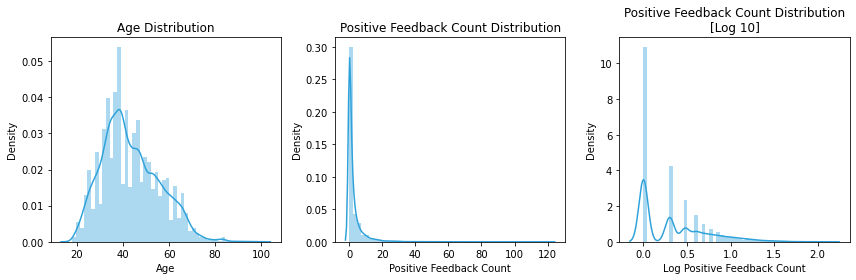

In [9]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

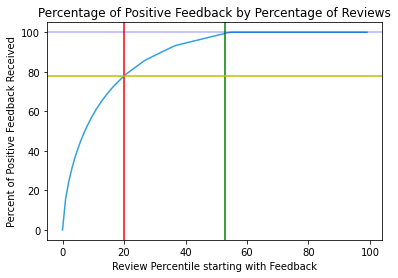

78% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.76


In [10]:
# Percentage Accumulation from "Most Wealthy"
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending=False)
            [:round(series.shape[0]*(percentage/100))]
     .sum()/series
     .sum()*100)

# Gini Coefficient- Inequality Score
# Source: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(df["Positive Feedback Count"], 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(df["Positive Feedback Count"]),2)))

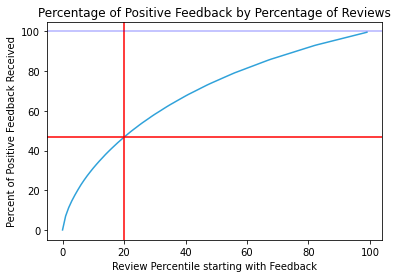

47% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.38


In [11]:
# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
top_20 = df["Positive Feedback Count"].sort_values(ascending=False)[:round(df.shape[0]*(20/100))]

inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(top_20, x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axhline(y=47, c = "r")
plt.axhline(y=100, c = "b", alpha=.3)

plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(top_20, 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(top_20),2)))

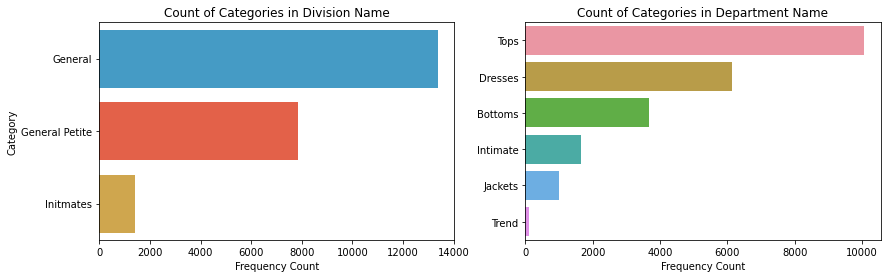

In [12]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

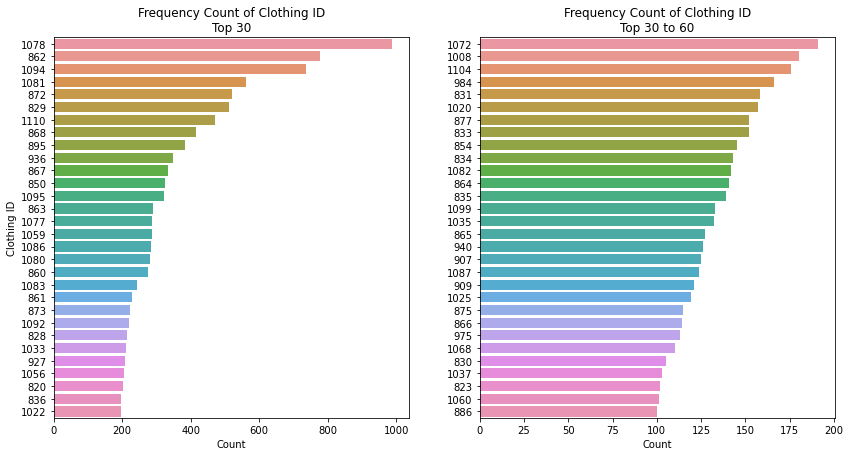

Dataframe Dimension: 22628 Rows


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.4848,103.396022,862.0,862.0,1078.0,1094.0,1094.0
Age,42.7248,12.150429,18.0,34.0,41.0,51.0,99.0
Rating,4.1892,1.104306,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.8184,0.385592,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.8624,6.773021,0.0,0.0,1.0,3.0,98.0
Word Count,60.5912,28.731486,2.0,36.0,60.0,89.0,115.0
Character Count,310.8604,144.836158,16.0,189.0,305.0,469.0,504.0
Label,0.9024,0.296832,0.0,1.0,1.0,1.0,1.0


In [13]:
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("Dataframe Dimension: {} Rows".format(df.shape[0]))
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

In [14]:
df.loc[df["Clothing ID"].isin([1078, 862,1094]),
       ["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,1815,Beautiful dress,21
Division Name,2,General,1524
Department Name,2,Dresses,1722
Class Name,2,Dresses,1722


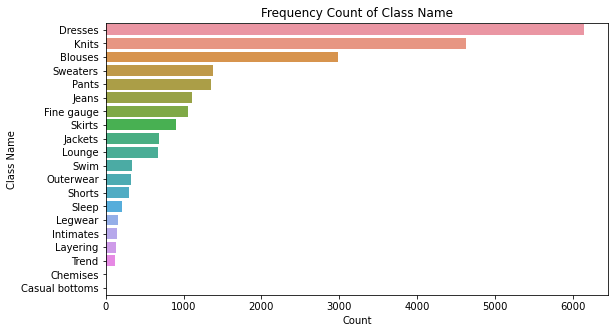

In [15]:
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

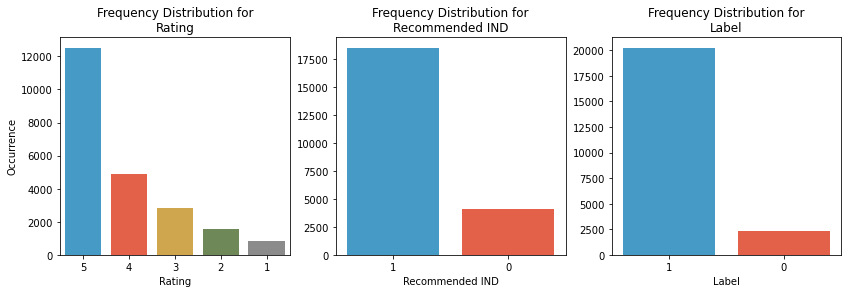

In [16]:
#cat_dtypes = [x for x,y,z in unique_count if y < 10 and x not in ["Division Name","Department Name"]]
cat_dtypes = ["Rating","Recommended IND","Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

AttributeError: 'NoneType' object has no attribute 'remove'

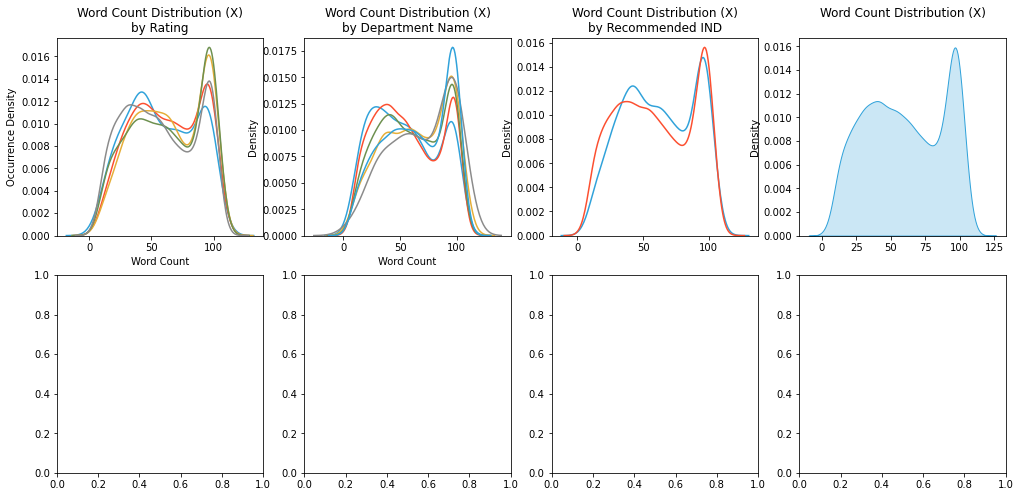

In [26]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

print("Correlation Coefficient of Word Cound and Character Count: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
print("Total Character Count is: {}".format(df["Character Count"].sum()))
df[["Word Count","Character Count"]].describe().T

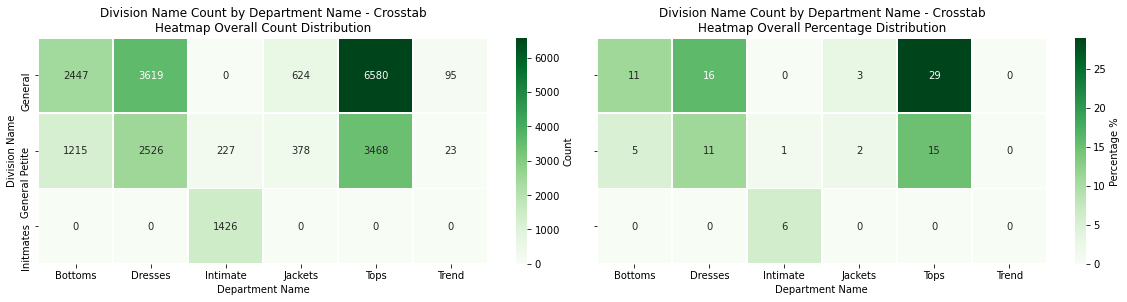

In [19]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

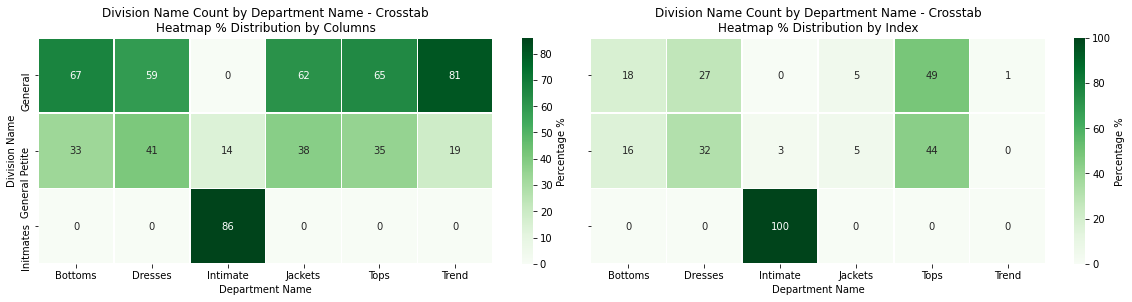

In [20]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

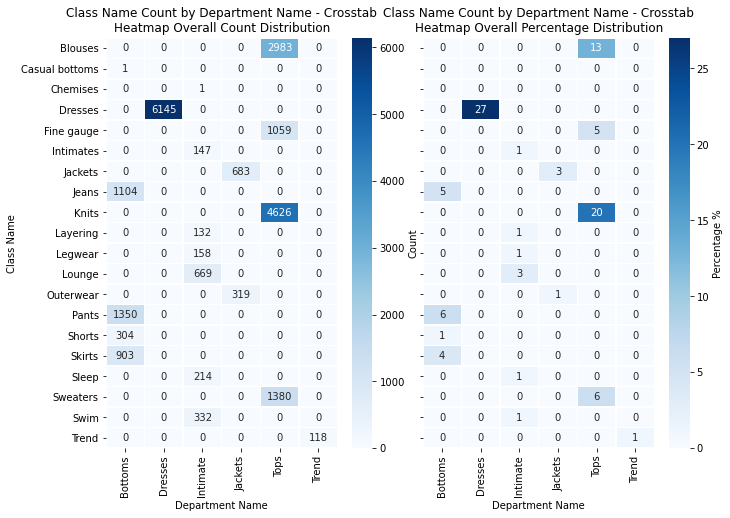

In [21]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

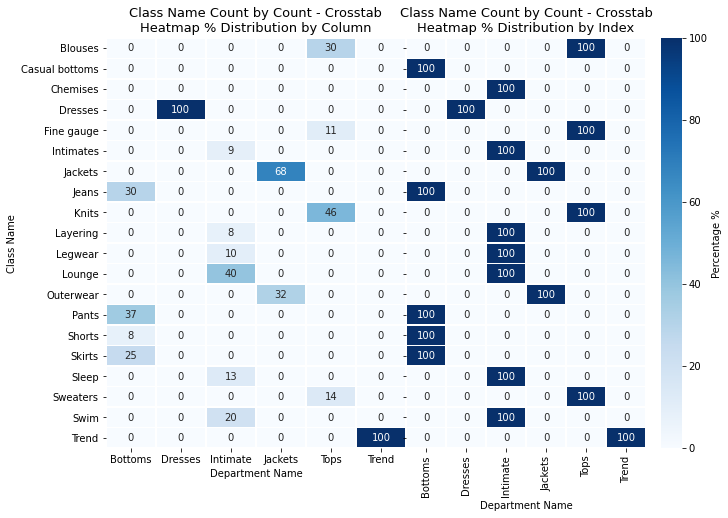

In [22]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Blues")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

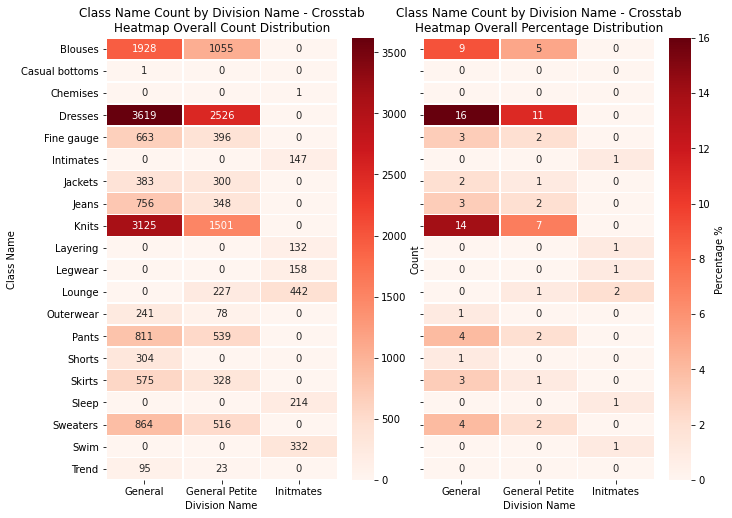

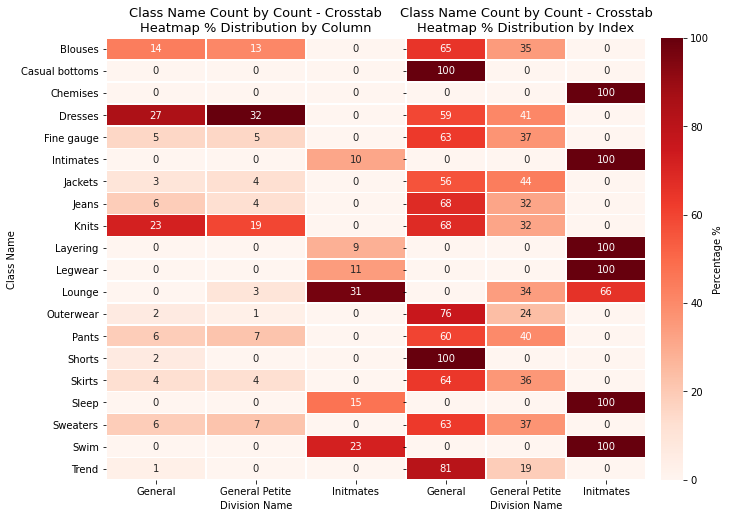

In [23]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Reds",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Reds")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)

# MANUAL NORMALIZE with Applied Lambda on Pandas DataFrame
# ctab = pd.crosstab(df['Class Name'], df["Rating"]).apply(lambda r: r/r.sum(), axis=1).mul(100)

AttributeError: 'NoneType' object has no attribute 'remove'

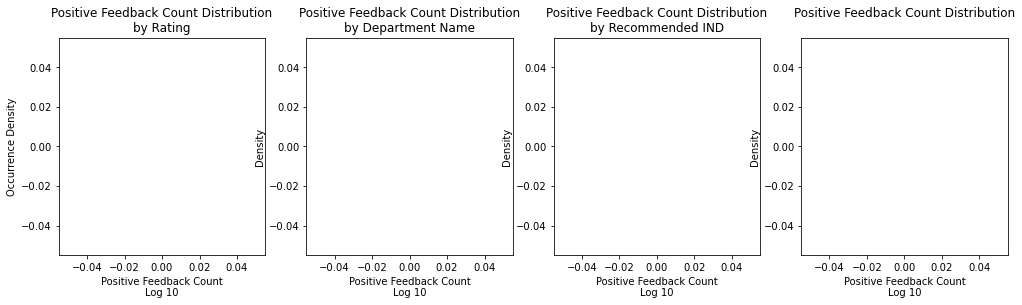

In [24]:
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')
# Plot 4
sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

In [ ]:
# Checking inequality difference:
for rec in [0,1]:
    temp = df["Positive Feedback Count"][df["Recommended IND"] == rec]

    print("Recommended is {}".format(rec))
    # 80-20 Rule Confirmation
    print("{}% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = {}".format(
        round(percentage_accumulation(temp, 20)),rec))
    # Gini
    print("Gini Coefficient: {}\n".format(round(gini(temp),2)))

AttributeError: 'NoneType' object has no attribute 'remove'

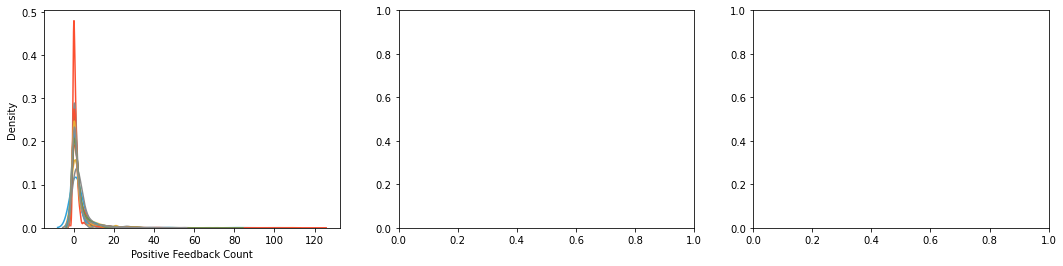

In [25]:
f, axes = plt.subplots(1,3, figsize=(18,4), sharex=False)
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[0])
    
axes[0].legend_.remove()
axes[0].set_xlabel('{}'.format(xvar))
axes[0].set_title('{} Distribution by {}\n All Data'.format(xvar, "Class Name"))

min_value = 15
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][(df["Class Name"]==x) &
                                              (df["Positive Feedback Count"] < min_value)]
                ,label=x, shade=False, ax=axes[1])
    
axes[1].legend_.remove()
axes[1].set_xlabel('{}'.format(xvar))
axes[1].set_title('{} Distribution by {}\n Values under {}'.format(xvar, "Class Name", min_value))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(np.log10(df['Positive Feedback Count']+1)[df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[2])
    
axes[2].legend_.remove()
axes[2].set_xlabel('Log 10 - {}'.format(xvar))
axes[2].set_title('{} Distribution by {}\nAll Data in Log10'.format(xvar, "Class Name"))
plt.show()